In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import signal

In [515]:
grid_size = 4
n_spots = grid_size**2
n_yellow = n_spots // 3
n_blue = n_spots // 3

def plot_grid(gs=None,ax=None):
    if ax is None:
        ax = plt.subplot(111)
    if gs is None:
        gs = 10
        
    
    ax.set_xticks(np.arange(gs+1)-0.5)
    ax.set_yticks(np.arange(gs+1)-0.5)
    ax.set_xlim(-0.5,gs-0.5)
    ax.set_ylim(-0.5,gs-0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect(1)
    ax.grid(True)
        

In [308]:
grid=np.mgrid[:3,:3]

np.mgrid[:2,:2],np.indices((2,2))

(array([[[0, 0],
         [1, 1]],
 
        [[0, 1],
         [0, 1]]]), array([[[0, 0],
         [1, 1]],
 
        [[0, 1],
         [0, 1]]]))

/Users/johnlewis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/Users/johnlewis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


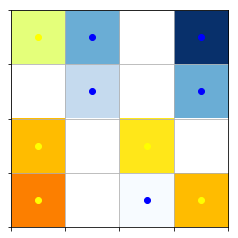

In [289]:
world = np.zeros((grid_size,grid_size))

grid = np.mgrid[:grid_size,:grid_size]

fig = plt.figure(figsize=(5,4))
ax = plt.subplot(111)
plot_grid(grid_size,ax)
#plt.scatter(xs,ys,marker='.',c='red')

np.random.seed(4)
positions = np.random.choice(np.indices(grid[0].ravel().shape)[0],size=n_yellow+n_blue,replace=False)

y_yellow, x_yellow = np.unravel_index(positions[:n_yellow],grid[0].shape)
y_blue, x_blue = np.unravel_index(positions[n_yellow:n_yellow+n_blue],grid[0].shape)

plt.scatter(x_blue,y_blue,c='b',marker='o')
plt.scatter(x_yellow,y_yellow,c='yellow',marker='o')

yellow_world = np.zeros((grid_size,grid_size))
yellow_world[y_yellow, x_yellow] = 1

blue_world = np.zeros((grid_size,grid_size))
blue_world[y_blue, x_blue] = 1

footprint = np.ones((3,3))
footprint[1,1] = 0

yellow = yellow_world > 0
blue = blue_world > 0
    

blue_same = signal.convolve2d(blue_world,footprint,mode='same') * blue
yellow_same = signal.convolve2d(yellow_world,footprint,mode='same') * yellow
neighbors = signal.convolve2d(yellow_world+blue_world,footprint,mode='same').astype(float) * (blue | yellow) #ncells - nones

nones = signal.convolve2d(-blue_world - yellow_world + 1, footprint,mode='same') * (blue | yellow)
ncells = signal.convolve2d(world+1, footprint,mode='same') * (blue | yellow)

yellow_sameness = yellow_same / neighbors
blue_sameness = blue_same / neighbors


cmap = mpl.cm.get_cmap('Greys',8)
plt.imshow(np.ma.masked_array(yellow_sameness,~yellow),origin='lower',cmap='Wistia',vmin=0,vmax=1)
plt.imshow(np.ma.masked_array(blue_sameness,~blue),origin='lower',cmap='Blues',vmin=0,vmax=1)

[[ 1.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]]


In [282]:
def count_neighbors(p,w):
    n = p*0 # create an array the same as p with all zeros
    # there are at most nine neighbors
    for i,p_i in enumerate(p):
        for j,p_j in enumerate(p_i):
            if p[i,j]>0:
                for i_inc in [-1,0,1]:
                    for j_inc in [-1,0,1]:
                        if abs(i_inc) + abs(j_inc) > 0:
                            if (0<=i+i_inc<p.shape[0]) & (0<=j+j_inc<p.shape[1]):
                                n[i,j] += w[i+i_inc,j+j_inc]

    return n.astype(float)

In [283]:
%%capture --no-stdout
ny = count_neighbors(yellow_world,yellow_world) # get # neighbors for yellow
nb = count_neighbors(blue_world,blue_world) # get # of neighbors for blue
nbs = count_neighbors(yellow_world+blue_world,yellow_world+blue_world)
y_sameness = ny/nbs
y_sameness[nbs==0] = 1
b_sameness = nb/nbs
b_sameness[nbs==0] = 1

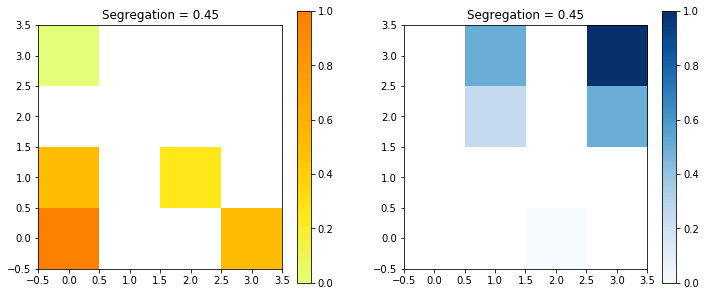

In [285]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(np.ma.masked_array(y_sameness,~yellow),origin='lower',cmap='Wistia',vmin=0)
plt.colorbar()
plt.title('Segregation = {:0.2f}'.format(seg(y_sameness[yellow])))

plt.subplot(122)
plt.imshow(np.ma.masked_array(b_sameness,~blue),origin='lower',cmap='Blues',vmin=0)
plt.title('Segregation = {:0.2f}'.format(seg(b_sameness[blue])))
plt.colorbar()


## Version 2

Some problems with this implementation:
- If it doesn't find a solution, it stops after 1000 loops. 
- Not yet fully tested
- Haven't checked segragation calculcation yet, but math is there

Good things
- Everything has a place
- It is at least complete, if not bug checked
- It works, and seems to work right

In [ ]:
## check fsegregation has asymptote
def checkAsymptote(s):
    '''
    check if length 1000 array has asymptoted
    !!!!Very not general. Very bad way!!!!
    '''
    if len(s>1000):
        if np.isclose(np.max(s[500:750]),np.max(s[750:1000])):
            return True
        else:
            return False
    else:
        return False
    
### RATHER THAN DO THIS, LIMIT TO 100 moves

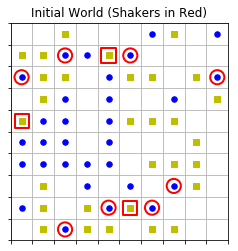

In [560]:
np.random.seed(41) #gives a nice board setup

def isFilled(x,y,tmpx,tmpy):
    '''
    check if location tmpx,tmpy
    is in x,y
    '''
    if (tmpx,tmpy) in zip(x,y):
        return True
    else:
        return False
    
def findEmptySpot(x,y,grid_size):
    '''
    find a random empty spot the grid
    '''
    spotFilled=True
    while spotFilled:
        tmpx = np.random.randint(low=0,high=grid_size)
        tmpy = np.random.randint(low=0,high=grid_size)
        spotFilled = isFilled(x,y,tmpx,tmpy)
    return tmpx,tmpy

def getEmptySpots(x,y,grid_size):
    '''
    get all empty spots in the grid.
    Doing this takes longer the
    finding single random one
    '''
    empty_x,empty_y = np.array([]),np.array([])
    for tmpx in range(grid_size):
        for tmpy in range(grid_size):
            if not isFilled(x,y,tmpx,tmpy):
                empty_x = np.append(empty_x,tmpx)
                empty_y = np.append(empty_y,tmpy)
    return empty_x, empty_y

def get_1_sameness(x0,y0,k0,x,y,k):
    '''
    get the sameness for a single location our world
    '''
    dx = x-x0
    dy = y-y0
    dist = dx**2 + dy**2
    NN = np.sum(dist<2) #neighbors
    NS = np.sum((dist < 2) & (k==k0)) #same
    sameness = NS/NN
    
    if sameness < 0:
        return 0
    if NN == 0:
        return 1
    else:
        return sameness

def getSameness(x,y,k):
    '''
    get sameness for every x,y position in our world
    '''
    neighbors = []
    sameness = []
    for i in range(len(x)):
        sameness = np.append(sameness,get_1_sameness(x[i],y[i],k[i],x,y,k))
        
    return sameness 

def find_1_EmptyHappySpot(k0,x,y,k,grid_size):
    '''
    find the first spot that is both empty and would be happy
    This was the first function i wrote. But this does
    a poor job of picking good locations. And tends to 
    get stuck in cycles
    '''
    emptyx, emptyy = getEmptySpots(x,y,grid_size)
    shaking = []
    for i in range(len(emptyx)):
        if get_1_sameness(emptyx[i],emptyy[i],k0,x,y,k)<SHAKE_LIMIT:
            return emptyx[i],emptyy[i]

def find_1_EmptyHappySpot(k0,x,y,k,grid_size):
    '''
    find a random spot that is both empty and would be happy
    '''
    emptyx, emptyy = getEmptySpots(x,y,grid_size)
    doLoop = True 
    while doLoop:
        i = np.random.randint(low=0,high=len(emptyx))
        if get_1_sameness(emptyx[i],emptyy[i],k0,x,y,k)<SHAKE_LIMIT:
            return emptyx[i],emptyy[i]


## create world
grid_size = 10 # define grid
n_spots = grid_size**2

num_a = 30 # 1's
num_b = 30 # -1's

SHAKE_LIMIT = .50 # shake if <66% are like you, seems to work well

# give me empty x,y,k (kind) arrays
#   there are better ways. 
#   like creating arrays, but it's just
x = np.array([])
y = np.array([])
k = np.array([]) #kind
seg = np.array([]) #segregation

## place in random empty spots for As
for i in range(num_a):
    tmpx,tmpy = findEmptySpot(x,y,grid_size)
    x = np.append(x,tmpx)
    y = np.append(y,tmpy)
    k = np.append(k,1) #kind a
## place in random empty spots for Bs
for i in range(num_b):
    tmpx,tmpy = findEmptySpot(x,y,grid_size)
    x = np.append(x,tmpx)
    y = np.append(y,tmpy)
    k = np.append(k,-1) #kind b
# the above two loops can be combined by being smart with k and an if statement


## calculate parameters for initialization
sameness = getSameness(x,y,k)
shaking = sameness < SHAKE_LIMIT #if sameness too low, start shaking
seg = np.append(seg,(np.mean(sameness)-0.5)*2)
                
                
# make an initial world plot
ax = plt.subplot(111)
plot_grid(grid_size,ax)

ax.scatter(x[(k==1)],y[(k==1)],c='b',marker='o',s=30,edgecolors=None)
ax.scatter(x[(k==1) & shaking],y[(k==1) & shaking],c='None',marker='o',edgecolors='r',lw=2,s=200)

ax.scatter(x[(k==-1)],y[(k==-1)],c='y',marker='s',s=30,edgecolors=None)
ax.scatter(x[(k==-1) & shaking],y[(k==-1) & shaking],c='None',marker='s',edgecolors='r',lw=2,s=200)
plt.title('Initial World (Shakers in Red)');

## Move Step

In [559]:
%%capture --no-stdout
# hide some division errors ;)

## move
# Only do this if something is shaking.
hasShakers = True in shaking
loop = 1
while hasShakers:
    # find the first shaker
    # probably best to get a random shaker (likely why were asympt.)
    i = shaking.tolist().index(True) # this will find the first shaker
    # find a new spot
    tmpx,tmpy = find_1_EmptyHappySpot(k[i],x,y,k,grid_size)
    #**** update steps
    x[i] = tmpx
    y[i] = tmpy
    sameness = getSameness(x,y,k)
    shaking = sameness < SHAKE_LIMIT
    #*****
    seg = (np.append(seg,(np.mean(sameness)- 0.5)*2))
    hasShakers = True in shaking
    loop+=1
    
    # let's not run too long. But if we need to, then do so
    if loop % 1000 == 0:
        if (checkAsymptote(seg)):
            hasShakers=False
        else:
            print(loop)
    

print(loop)

1


(array([ -5.,   0.,   5.,  10.,  15.,  20.,  25.,  30.]),
 <a list of 8 Text xticklabel objects>)

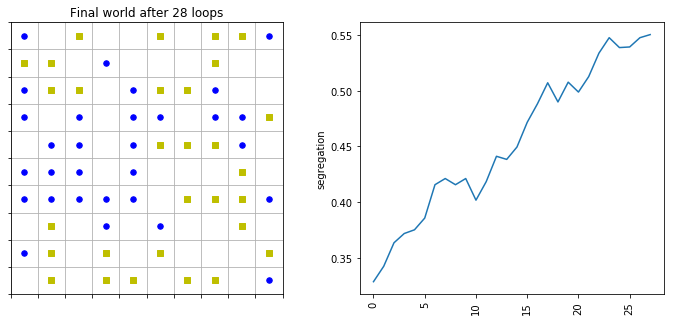

In [558]:
plt.figure(figsize=(12,5))
ax = plt.subplot(121)
plot_grid(grid_size,ax)

ax.scatter(x[(k==1)],y[(k==1)],c='b',marker='o',s=30,edgecolors=None)
ax.scatter(x[(k==1) & shaking],y[(k==1) & shaking],c='None',marker='o',edgecolors='r',lw=2,s=200)

ax.scatter(x[(k==-1)],y[(k==-1)],c='y',marker='s',s=30,edgecolors=None)
ax.scatter(x[(k==-1) & shaking],y[(k==-1) & shaking],c='None',marker='s',edgecolors='r',lw=2,s=200)
plt.title('Final world after {loop} loops'.format(loop=loop))

ax2 = plt.subplot(122)
if len(seg) < 2:
    ax2.scatter([0],[seg])
if len(seg)>100:
    ax2.plot(seg[:100])
else:
    ax2.plot(seg)
ax2.set_ylabel('segregation')
plt.xticks(rotation=90)

Driver:
- create
- place
- move
- trace
- plot

x, y, kind, sameness, 

```
o o _ _ _
o o _ _ _
_ _ _ x x
_ _ x x x
```
___
```
o x o _ _
x o x _ _
_ _ _ _ _
_ _ _ _ _
```

## Set up

In [ ]:
## get everybody placed

## Define Functions

## Movement

## Seg vs t